## Step 1: Import Required Libraries

We'll use standard Python data science libraries. All of these should be available in your environment.

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Handling imbalanced data
from imblearn.over_sampling import SMOTE

# Evaluation metrics
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, roc_curve,
    precision_recall_curve, auc
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model persistence
import joblib

# Set random seed for reproducibility
np.random.seed(42)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


---

## Step 2: Generate Synthetic Email Phishing Dataset

For this tutorial, we'll create a realistic synthetic dataset. In practice, you'd load real data from your email security systems.

**Dataset Features** (email characteristics):
- `num_links`: Number of hyperlinks in email
- `num_misspellings`: Count of spelling errors
- `has_attachment`: Attachment present (0/1)
- `urgency_words`: Count of urgency keywords ("urgent", "immediate", "expire")
- `sender_reputation`: Sender reputation score (0-100)
- `email_length`: Length of email body (characters)
- `label`: 0 = legitimate, 1 = phishing

In [2]:
def generate_email_dataset(n_samples=1000, phishing_ratio=0.1):
    """
    Generate synthetic email phishing detection dataset.
    
    Parameters:
    - n_samples: Total number of samples
    - phishing_ratio: Proportion of phishing emails (e.g., 0.1 = 10%)
    """
    n_phishing = int(n_samples * phishing_ratio)
    n_legitimate = n_samples - n_phishing
    
    # Generate LEGITIMATE email features
    legitimate_data = {
        'num_links': np.random.poisson(2, n_legitimate),
        'num_misspellings': np.random.poisson(1, n_legitimate),
        'has_attachment': np.random.choice([0, 1], n_legitimate, p=[0.7, 0.3]),
        'urgency_words': np.random.poisson(0.5, n_legitimate),
        'sender_reputation': np.random.normal(75, 10, n_legitimate).clip(0, 100),
        'email_length': np.random.normal(500, 200, n_legitimate).clip(50, 2000),
        'label': np.zeros(n_legitimate, dtype=int)
    }
    
    # Generate PHISHING email features (different distributions)
    phishing_data = {
        'num_links': np.random.poisson(8, n_phishing),  # More links
        'num_misspellings': np.random.poisson(5, n_phishing),  # More spelling errors
        'has_attachment': np.random.choice([0, 1], n_phishing, p=[0.4, 0.6]),  # More attachments
        'urgency_words': np.random.poisson(4, n_phishing),  # More urgency
        'sender_reputation': np.random.normal(30, 15, n_phishing).clip(0, 100),  # Lower reputation
        'email_length': np.random.normal(300, 150, n_phishing).clip(50, 1500),  # Shorter emails
        'label': np.ones(n_phishing, dtype=int)
    }
    
    # Combine and shuffle
    df_legitimate = pd.DataFrame(legitimate_data)
    df_phishing = pd.DataFrame(phishing_data)
    df = pd.concat([df_legitimate, df_phishing], ignore_index=True)
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle
    
    return df

# Generate dataset
df = generate_email_dataset(n_samples=1000, phishing_ratio=0.1)

print(f"✅ Generated dataset with {len(df)} samples")
print(f"   - Legitimate emails: {(df['label'] == 0).sum()}")
print(f"   - Phishing emails: {(df['label'] == 1).sum()}")
print(f"   - Imbalance ratio: {(df['label'] == 0).sum() / (df['label'] == 1).sum():.1f}:1")

✅ Generated dataset with 1000 samples
   - Legitimate emails: 900
   - Phishing emails: 100
   - Imbalance ratio: 9.0:1


---

## Step 3: Explore the Data

Always look at your data before building models! Understanding the data helps you make better decisions.

In [3]:
# Display first few rows
print("📊 First 5 samples:")
print(df.head())
print()

# Basic statistics
print("📈 Statistical summary:")
print(df.describe())
print()

# Check for missing values
print("❓ Missing values:")
print(df.isnull().sum())

📊 First 5 samples:
   num_links  num_misspellings  has_attachment  urgency_words  \
0          1                 4               0              0   
1          2                 3               0              0   
2          3                 0               1              0   
3          1                 2               1              0   
4          2                 2               0              0   

   sender_reputation  email_length  label  
0          49.934284    359.417712      0  
1          59.143743    428.401913      0  
2          74.412796     78.032352      0  
3          65.332981    588.463374      0  
4          71.581782    549.007733      0  

📈 Statistical summary:
         num_links  num_misspellings  has_attachment  urgency_words  \
count  1000.000000       1000.000000     1000.000000    1000.000000   
mean      2.606000          1.338000        0.341000       0.851000   
std       2.439819          1.686001        0.474283       1.398125   
min       0.000000

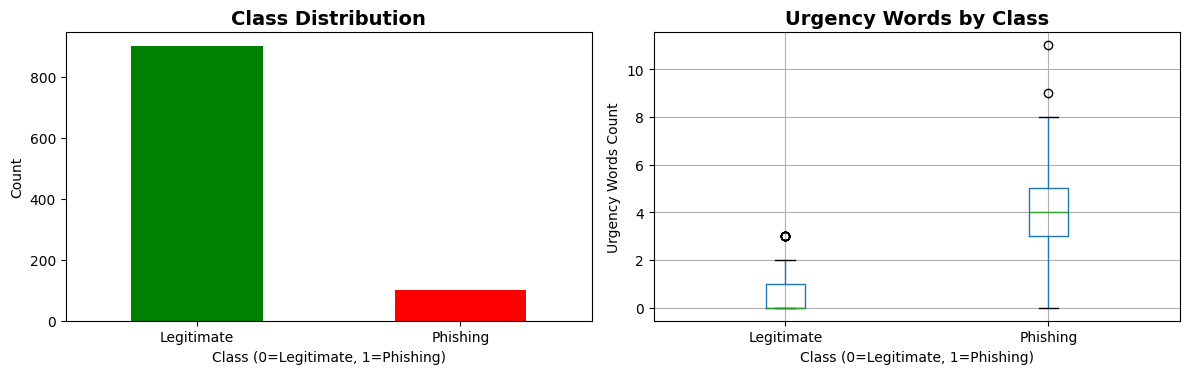


💡 Observation: Phishing emails tend to have more urgency keywords


In [4]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Class counts
df['label'].value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red'])
axes[0].set_title('Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class (0=Legitimate, 1=Phishing)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Legitimate', 'Phishing'], rotation=0)

# Feature comparison: urgency_words
df.boxplot(column='urgency_words', by='label', ax=axes[1])
axes[1].set_title('Urgency Words by Class', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Class (0=Legitimate, 1=Phishing)')
axes[1].set_ylabel('Urgency Words Count')
axes[1].set_xticklabels(['Legitimate', 'Phishing'])

plt.suptitle('')  # Remove default title
plt.tight_layout()
plt.show()

print("\n💡 Observation: Phishing emails tend to have more urgency keywords")

---

## Step 4: Split Data into Train and Test Sets

**Critical Rule:** Never train and test on the same data!

We'll split:
- **Training set (70%)**: Used to train the model
- **Test set (30%)**: Used to evaluate final performance (held-out data)

**Note:** We use `stratify=y` to maintain the same class ratio in both sets.

In [5]:
# Separate features (X) and target (y)
X = df.drop('label', axis=1)
y = df['label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3,      # 30% for testing
    random_state=42,    # For reproducibility
    stratify=y          # Maintain class ratio in both sets
)

print("✅ Data split completed!")
print(f"   - Training samples: {len(X_train)} ({len(X_train)/len(df)*100:.1f}%)")
print(f"   - Test samples: {len(X_test)} ({len(X_test)/len(df)*100:.1f}%)")
print()
print("Training set distribution:")
print(f"   - Legitimate: {(y_train == 0).sum()}")
print(f"   - Phishing: {(y_train == 1).sum()}")
print()
print("Test set distribution:")
print(f"   - Legitimate: {(y_test == 0).sum()}")
print(f"   - Phishing: {(y_test == 1).sum()}")

✅ Data split completed!
   - Training samples: 700 (70.0%)
   - Test samples: 300 (30.0%)

Training set distribution:
   - Legitimate: 630
   - Phishing: 70

Test set distribution:
   - Legitimate: 270
   - Phishing: 30


---

## Step 5: Handle Class Imbalance with SMOTE

**Problem:** We have 9x more legitimate emails than phishing emails. This causes models to be biased toward predicting "legitimate."

**Solution:** SMOTE (Synthetic Minority Over-sampling Technique) creates synthetic phishing samples by interpolating between existing ones.

⚠️ **Important:** Only apply SMOTE to training data, never test data!

In [6]:
print("Before SMOTE:")
print(f"   - Legitimate: {(y_train == 0).sum()}")
print(f"   - Phishing: {(y_train == 1).sum()}")
print(f"   - Ratio: {(y_train == 0).sum() / (y_train == 1).sum():.2f}:1")

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("\nAfter SMOTE:")
print(f"   - Legitimate: {(y_train_balanced == 0).sum()}")
print(f"   - Phishing: {(y_train_balanced == 1).sum()}")
print(f"   - Ratio: {(y_train_balanced == 0).sum() / (y_train_balanced == 1).sum():.2f}:1")
print("\n✅ Classes are now balanced!")

Before SMOTE:
   - Legitimate: 630
   - Phishing: 70
   - Ratio: 9.00:1

After SMOTE:
   - Legitimate: 630
   - Phishing: 630
   - Ratio: 1.00:1

✅ Classes are now balanced!


---

## Step 6: Scale Features

Machine learning algorithms work better when features are on similar scales. We'll use StandardScaler to normalize features (mean=0, std=1).

⚠️ **Important:** Fit scaler on training data only, then apply to both train and test!

In [7]:
# Initialize scaler
scaler = StandardScaler()

# Fit on training data and transform
X_train_scaled = scaler.fit_transform(X_train_balanced)

# Transform test data (using training statistics)
X_test_scaled = scaler.transform(X_test)

print("✅ Feature scaling completed!")
print(f"   - Training features shape: {X_train_scaled.shape}")
print(f"   - Test features shape: {X_test_scaled.shape}")

✅ Feature scaling completed!
   - Training features shape: (1260, 6)
   - Test features shape: (300, 6)


---

## Step 7: Train the Model

We'll use **Random Forest** - a popular algorithm for security applications because:
- Handles high-dimensional data well
- Provides feature importance (interpretability)
- Robust to outliers
- Good performance out-of-the-box

In [8]:
# Initialize Random Forest classifier
model = RandomForestClassifier(
    n_estimators=100,      # Number of trees
    max_depth=10,          # Maximum tree depth
    random_state=42,       # For reproducibility
    n_jobs=-1              # Use all CPU cores
)

print("🌲 Training Random Forest classifier...")

# Train the model
model.fit(X_train_scaled, y_train_balanced)

print("✅ Model training completed!")
print(f"   - Number of trees: {model.n_estimators}")
print(f"   - Number of features: {model.n_features_in_}")

🌲 Training Random Forest classifier...
✅ Model training completed!
   - Number of trees: 100
   - Number of features: 6
✅ Model training completed!
   - Number of trees: 100
   - Number of features: 6


---

## Step 8: Make Predictions

Now let's use our trained model to predict on the test set.

In [9]:
# Predict classes (0 or 1)
y_pred = model.predict(X_test_scaled)

# Predict probabilities (for ROC curve later)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

print("✅ Predictions generated!")
print(f"   - Predicted legitimate: {(y_pred == 0).sum()}")
print(f"   - Predicted phishing: {(y_pred == 1).sum()}")
print()
print("Example predictions (first 10):")
comparison = pd.DataFrame({
    'Actual': y_test.values[:10],
    'Predicted': y_pred[:10],
    'Probability': y_pred_proba[:10]
}, index=range(1, 11))
comparison['Correct'] = comparison['Actual'] == comparison['Predicted']
print(comparison)

✅ Predictions generated!
   - Predicted legitimate: 270
   - Predicted phishing: 30

Example predictions (first 10):
    Actual  Predicted  Probability  Correct
1        0          0         0.00     True
2        0          0         0.00     True
3        0          0         0.02     True
4        0          0         0.00     True
5        0          0         0.00     True
6        0          0         0.00     True
7        0          0         0.00     True
8        0          0         0.00     True
9        0          0         0.00     True
10       0          0         0.00     True


---

## Step 9: Evaluate Model Performance

Let's measure how well our model performs using multiple metrics.

### 9.1 Confusion Matrix

A confusion matrix shows:
- **True Positives (TP)**: Correctly detected phishing emails
- **True Negatives (TN)**: Correctly identified legitimate emails
- **False Positives (FP)**: Legitimate emails incorrectly flagged as phishing (user frustration!)
- **False Negatives (FN)**: Phishing emails missed by the detector (dangerous!)

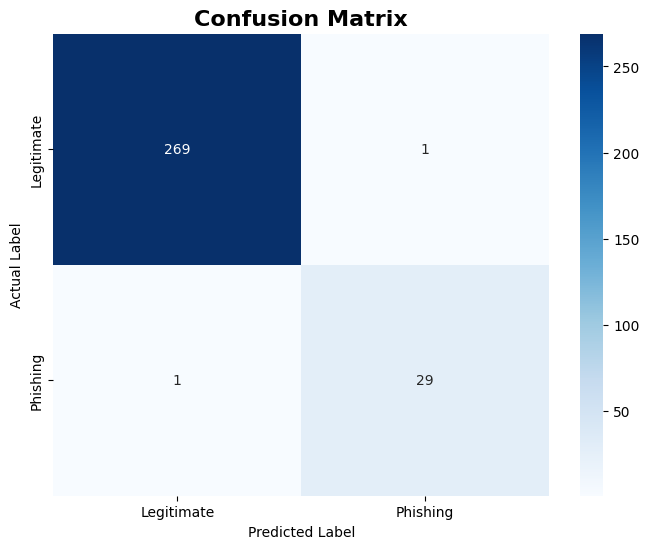


📊 Confusion Matrix Breakdown:
   - True Negatives (TN): 269 (correctly identified legitimate)
   - False Positives (FP): 1 (legitimate flagged as phishing)
   - False Negatives (FN): 1 (phishing emails missed!)
   - True Positives (TP): 29 (correctly detected phishing)


In [10]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Legitimate', 'Phishing'],
            yticklabels=['Legitimate', 'Phishing'])
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Extract values
tn, fp, fn, tp = cm.ravel()

print("\n📊 Confusion Matrix Breakdown:")
print(f"   - True Negatives (TN): {tn} (correctly identified legitimate)")
print(f"   - False Positives (FP): {fp} (legitimate flagged as phishing)")
print(f"   - False Negatives (FN): {fn} (phishing emails missed!)")
print(f"   - True Positives (TP): {tp} (correctly detected phishing)")

### 9.2 Classification Metrics

Key security metrics:
- **Precision**: Of all emails flagged as phishing, how many were actually phishing?
- **Recall (TPR)**: Of all actual phishing emails, how many did we catch?
- **F1-Score**: Harmonic mean of precision and recall
- **False Positive Rate (FPR)**: Of all legitimate emails, how many did we incorrectly flag?

In [11]:
# Generate classification report
print("📈 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Phishing']))

# Calculate additional security-specific metrics
tpr = tp / (tp + fn)  # True Positive Rate (Recall)
fpr = fp / (fp + tn)  # False Positive Rate
precision = tp / (tp + fp)

print("\n🎯 Security-Specific Metrics:")
print(f"   - Detection Rate (TPR): {tpr:.2%} (caught {tpr:.0%} of phishing)")
print(f"   - False Positive Rate: {fpr:.2%} (flagged {fpr:.0%} of legitimate emails)")
print(f"   - Precision: {precision:.2%} (of flagged emails, {precision:.0%} were phishing)")
print()
print("💡 In an organization with 10,000 emails/day:")
print(f"   - Expected false alarms: ~{int(9000 * fpr)} per day")
print(f"   - Expected missed phishing: ~{int(100 * (1-tpr))} per day")

📈 Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00       270
    Phishing       0.97      0.97      0.97        30

    accuracy                           0.99       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.99      0.99      0.99       300


🎯 Security-Specific Metrics:
   - Detection Rate (TPR): 96.67% (caught 97% of phishing)
   - False Positive Rate: 0.37% (flagged 0% of legitimate emails)
   - Precision: 96.67% (of flagged emails, 97% were phishing)

💡 In an organization with 10,000 emails/day:
   - Expected false alarms: ~33 per day
   - Expected missed phishing: ~3 per day


### 9.3 ROC Curve and AUC

The ROC (Receiver Operating Characteristic) curve shows the trade-off between detection rate (TPR) and false alarm rate (FPR).

**AUC (Area Under Curve)**: Overall measure of model quality (1.0 = perfect, 0.5 = random guessing)

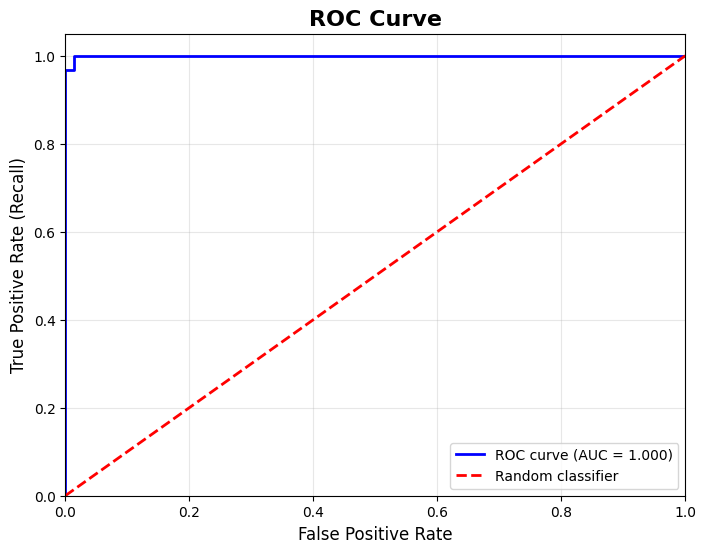


🎯 ROC-AUC Score: 1.000
   ✅ Excellent performance!


In [12]:
# Calculate ROC curve
fpr_curve, tpr_curve, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_curve, tpr_curve, color='blue', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', 
         label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('ROC Curve', fontsize=16, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f"\n🎯 ROC-AUC Score: {roc_auc:.3f}")
if roc_auc > 0.9:
    print("   ✅ Excellent performance!")
elif roc_auc > 0.8:
    print("   ✅ Good performance!")
elif roc_auc > 0.7:
    print("   ⚠️ Fair performance - room for improvement")
else:
    print("   ❌ Poor performance - model needs improvement")

---

## Step 10: Feature Importance

Random Forest tells us which features are most important for detection. This helps analysts understand *why* files are flagged.

🔍 Feature Importance Ranking:
             Feature  Importance
4  sender_reputation    0.374451
0          num_links    0.336499
1   num_misspellings    0.134895
3      urgency_words    0.111538
5       email_length    0.041244
2     has_attachment    0.001373


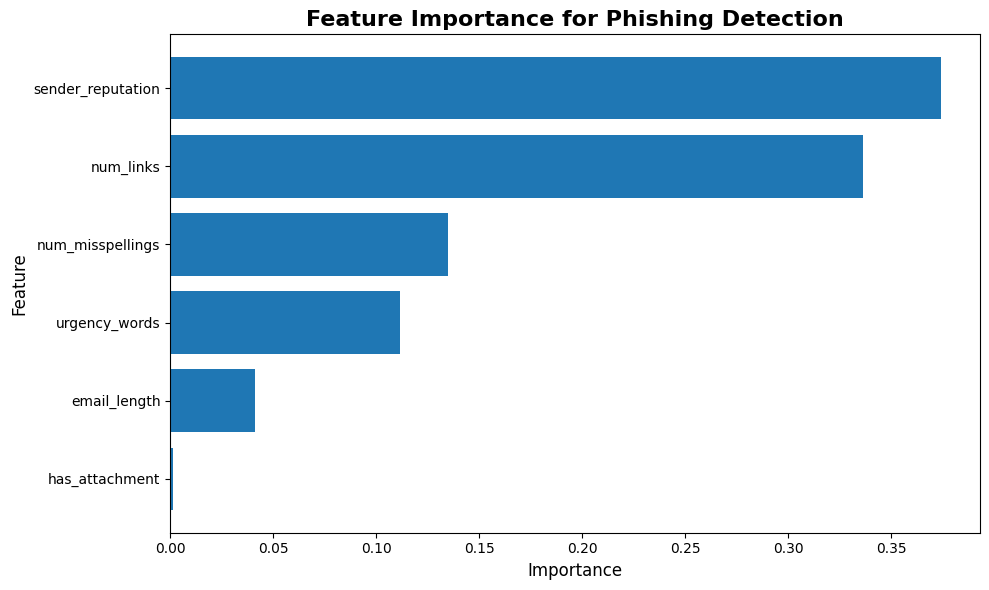


💡 Interpretation:
   - 'sender_reputation' is the most important feature for phishing detection
   - Security teams should pay special attention to this characteristic


In [13]:
# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("🔍 Feature Importance Ranking:")
print(feature_importance)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance for Phishing Detection', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
top_feature = feature_importance.iloc[0]['Feature']
print(f"   - '{top_feature}' is the most important feature for phishing detection")
print(f"   - Security teams should pay special attention to this characteristic")

---

## Step 11: Save the Model

Save the trained model and scaler so they can be deployed in production.

In [14]:
# Save model and scaler
model_filename = 'phishing_detector_model.pkl'
scaler_filename = 'phishing_detector_scaler.pkl'

joblib.dump(model, model_filename)
joblib.dump(scaler, scaler_filename)

print(f"✅ Model saved to: {model_filename}")
print(f"✅ Scaler saved to: {scaler_filename}")
print("\n💡 These files can now be loaded in production for real-time email filtering!")

✅ Model saved to: phishing_detector_model.pkl
✅ Scaler saved to: phishing_detector_scaler.pkl

💡 These files can now be loaded in production for real-time email filtering!


### Test Loading the Model

Verify we can load and use the saved model.

In [15]:
# Load saved model and scaler
loaded_model = joblib.load(model_filename)
loaded_scaler = joblib.load(scaler_filename)

# Test prediction on new data
sample_email = X_test.iloc[0:1]  # Take one sample
sample_scaled = loaded_scaler.transform(sample_email)
prediction = loaded_model.predict(sample_scaled)[0]
probability = loaded_model.predict_proba(sample_scaled)[0, 1]

print("✅ Model loaded successfully!")
print("\n🧪 Test prediction on sample email:")
print(f"   - Prediction: {'PHISHING' if prediction == 1 else 'LEGITIMATE'}")
print(f"   - Confidence: {probability:.2%}")
print(f"   - Actual label: {'PHISHING' if y_test.iloc[0] == 1 else 'LEGITIMATE'}")

✅ Model loaded successfully!

🧪 Test prediction on sample email:
   - Prediction: LEGITIMATE
   - Confidence: 0.00%
   - Actual label: LEGITIMATE


---

## 🎉 Congratulations!

You've successfully built a complete ML pipeline for email phishing detection! Here's what you accomplished:

### ✅ Skills Learned
1. ✅ Generated and explored email security dataset
2. ✅ Split data properly (train/test)
3. ✅ Handled class imbalance with SMOTE
4. ✅ Scaled features appropriately
5. ✅ Trained Random Forest classifier
6. ✅ Evaluated model with security metrics
7. ✅ Interpreted feature importance
8. ✅ Saved model for production deployment

### 📊 Your Model's Performance
- **ROC-AUC:** Shows overall discriminative ability
- **Precision:** Tells how accurate your alerts are
- **Recall:** Shows what % of malware you catch
- **FPR:** Indicates analyst workload from false alarms

---

## 🚀 Next Steps

To improve this pipeline further:

1. **Better Features**: Add NLP features (TF-IDF, word embeddings), header analysis, domain reputation scores
2. **Hyperparameter Tuning**: Optimize Random Forest parameters (max_depth, n_estimators, etc.)
3. **Try Other Algorithms**: Compare with XGBoost, Neural Networks, or Naive Bayes
4. **Threshold Optimization**: Use cost-benefit analysis to set optimal detection threshold
5. **Temporal Validation**: Test on future data to check for evolving phishing tactics
6. **Production Deployment**: Integrate with email gateway for real-time filtering

---

## 📚 Additional Exercises

Try these challenges to deepen your understanding:

### Challenge 1: Different Imbalance Ratio
Re-run the pipeline with `phishing_ratio=0.01` (1% phishing). How does this affect performance?

### Challenge 2: Feature Engineering
Add a new feature: `link_density = num_links / email_length * 1000`. Does it improve detection?

### Challenge 3: Cost-Sensitive Threshold
If a false positive costs \$5 (user frustration) and a false negative costs \$10,000 (credential compromise), what threshold minimizes total cost?

### Challenge 4: Compare Algorithms
Train a Naive Bayes model (commonly used for text/email). How does it compare to Random Forest?

---

## 📖 Further Reading

- **Chapter 5.2**: Model Construction (detailed theory)
- **Chapter 5.4**: Model Validation and Evaluation
- **Exercise 5.4A-C**: Advanced threshold optimization with Youden Index
- **Scikit-learn Documentation**: https://scikit-learn.org/

---

**Course:** Module 3 - Data Science & ML Foundations, Chapter 5  
**Exercise:** 5.2A (Simplified Teaching Assistant Tutorial)  
**Version:** 1.0  
**Last Updated:** November 2025